### Clusterização/segmentação dos Clientes usando o RFM (recencia, frequencia, valor monetario gasto)
- Segmentação é basicamente uma técnica de aprendizagem não-supervisionada, o algoritmo vai procurar por grupos naturais nos dados sem que seja necessário dizer a ele quais são esses grupos.

#### Criando tabelas para este notebook

In [2]:
import pandas as pd
import snowflake.connector
import os
from dotenv import load_dotenv
from pathlib import Path

# Carrega as variáveis de ambiente
env_path = Path('.') / 'environment.env'
load_dotenv(dotenv_path=env_path)
SF_USER = os.getenv("SF_USER")
SF_PASSWORD = os.getenv("SF_PASSWORD")
SF_ACCOUNT = os.getenv("SF_ACCOUNT")
SF_WAREHOUSE = os.getenv("SF_WAREHOUSE")
SF_DATABASE = os.getenv("SF_DATABASE")
SF_SCHEMA = os.getenv("SF_SCHEMA")

# Conecta ao Snowflake
conn = snowflake.connector.connect(
    user=SF_USER,
    password=SF_PASSWORD,
    account=SF_ACCOUNT,
    warehouse=SF_WAREHOUSE,
    database=SF_DATABASE,
    schema=SF_SCHEMA
)

# Carrega as tabelas
print("Carregando tabelas do Snowflake...")
df_orders = pd.read_sql("SELECT * FROM orders_refined", conn)
df_orders_reviews = pd.read_sql("SELECT * FROM order_reviews_refined", conn)
df_order_payments = pd.read_sql("SELECT * FROM order_payments_refined", conn)
df_order_items = pd.read_sql("SELECT * FROM order_items_refined", conn)
df_products = pd.read_sql("SELECT * FROM products_refined", conn)
df_customers = pd.read_sql("SELECT * FROM customers_refined", conn)

# Fecha a conexão
conn.close()

# Padroniza os nomes das colunas
for df in [df_orders, df_orders_reviews, df_order_payments, df_order_items, df_products, df_customers]:
    df.columns = df.columns.str.lower()

# Realiza as junções sequenciais
print("Unindo as tabelas...")
df_full_orders = df_orders.merge(df_orders_reviews, on='order_id', how='left')
df_full_orders = df_full_orders.merge(df_order_payments, on='order_id', how='left')
df_full_orders = df_full_orders.merge(df_order_items, on='order_id', how='left')
df_full_orders = df_full_orders.merge(df_products, on='product_id', how='left')
df_full_orders = df_full_orders.merge(
    df_customers[['customer_id', 'customer_state', 'customer_zip_code_prefix']],
    on='customer_id',
    how='left'
)

# Salva o DataFrame completo em um arquivo CSV
print("Salvando o DataFrame completo em olist_full_dataset.csv...")
df_full_orders.to_csv('olist_full_dataset.csv', index=False)

print("Processo concluído. O arquivo 'olist_full_dataset.csv' foi criado com sucesso!")

Carregando tabelas do Snowflake...


C:\Users\pacie\AppData\Local\Temp\ipykernel_24432\1455172169.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_orders = pd.read_sql("SELECT * FROM orders_refined", conn)
C:\Users\pacie\AppData\Local\Temp\ipykernel_24432\1455172169.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_orders_reviews = pd.read_sql("SELECT * FROM order_reviews_refined", conn)
C:\Users\pacie\AppData\Local\Temp\ipykernel_24432\1455172169.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_order_payments = pd.read_sql("SELECT * FROM o

Unindo as tabelas...
Salvando o DataFrame completo em olist_full_dataset.csv...
Processo concluído. O arquivo 'olist_full_dataset.csv' foi criado com sucesso!


Preparando dados para análise RFM...


C:\Users\pacie\AppData\Local\Temp\ipykernel_24432\4137335809.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_df['review_score'].fillna(rfm_df['review_score'].mean(), inplace=True)



Encontrando o número ideal de clusters...


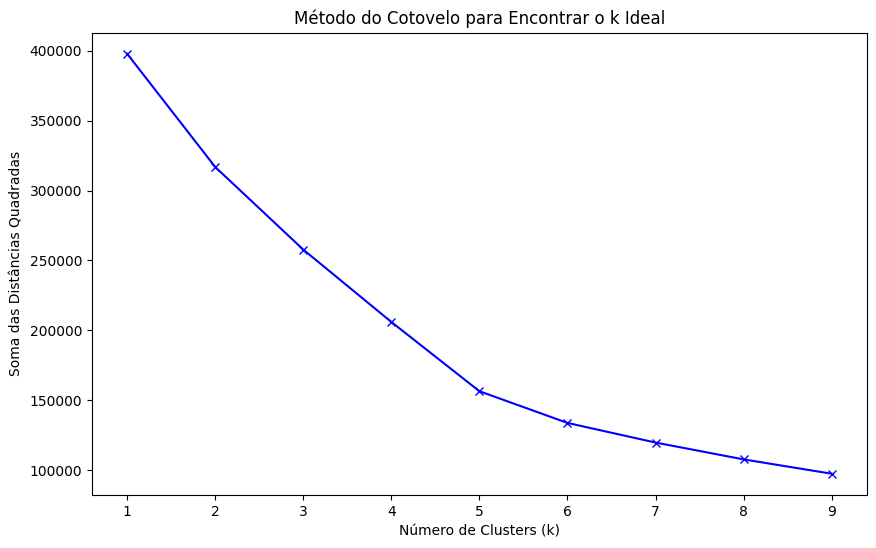


--- Interpretação do Método do Cotovelo ---
O 'k' ideal é o ponto na curva onde a diminuição do erro começa a se achatar, formando um 'cotovelo'.
Você deve escolher um 'k' nesse ponto para ter um bom equilíbrio entre o número de clusters e o quão bem os dados são agrupados.

--- Análise e Caracterização dos Segmentos de Clientes ---
   cluster  recency_days  frequency_orders  monetary_value  review_score
0        0    173.711840          1.026224      152.416831      4.664866
1        1    332.000000          6.258993      146.690827      4.108226
2        2    444.588026          1.034154      156.882139      4.625627
3        3    293.127950          1.032125      190.843258      1.586671

Salvando o DataFrame de segmentos em 'olist_customer_segments.csv'...
Arquivo 'olist_customer_segments.csv' criado com sucesso!


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# Supondo que df_orders, df_order_payments e df_orders_reviews já estão carregados na sua sessão.

# FUNÇÃO DE CONVERSÃO: Necessária para lidar com os timestamps
def safe_timestamp_to_datetime(series):
    series = pd.to_numeric(series, errors='coerce')
    if series.dropna().empty:
        return pd.NaT
    max_val = series.max()
    if max_val > 1e18:           # nanosegundos
        unit = 'ns'
    elif max_val > 1e12:         # milissegundos
        unit = 'ms'
    else:                        # segundos
        unit = 's'
    return pd.to_datetime(series, unit=unit, errors='coerce')


# --- 1. Preparação dos Dados para Análise RFM ---
print("Preparando dados para análise RFM...")

df_orders['order_purchase_datetime'] = safe_timestamp_to_datetime(df_orders['order_purchase_timestamp'])
df_orders_reviews['review_creation_datetime'] = safe_timestamp_to_datetime(df_orders_reviews['review_creation_ts'])
df_order_payments['payment_value'] = pd.to_numeric(df_order_payments['payment_value'], errors='coerce')

# 💡 CORREÇÃO: Converte a coluna 'review_score' para numérico antes de ser usada no groupby
df_orders_reviews['review_score'] = pd.to_numeric(df_orders_reviews['review_score'], errors='coerce')
df_orders_reviews.dropna(subset=['review_score'], inplace=True)

df_customers_orders = df_orders.merge(
    df_order_payments[['order_id', 'payment_value']],
    on='order_id',
    how='inner'
)
df_customers_reviews = df_orders.merge(
    df_orders_reviews[['order_id', 'review_score']],
    on='order_id',
    how='inner'
)

reference_date = df_customers_orders['order_purchase_datetime'].max() + pd.DateOffset(days=1)
rfm_df = df_customers_orders.groupby('customer_id').agg(
    recency_days=('order_purchase_datetime', lambda x: (reference_date - x.max()).days),
    frequency_orders=('order_id', 'count'),
    monetary_value=('payment_value', 'sum')
).reset_index()

avg_review_score = df_customers_reviews.groupby('customer_id')['review_score'].mean().reset_index()
rfm_df = rfm_df.merge(avg_review_score, on='customer_id', how='left')

# Tratamento de nulos para o K-Means
rfm_df.dropna(subset=['recency_days', 'frequency_orders', 'monetary_value'], inplace=True)
rfm_df['review_score'].fillna(rfm_df['review_score'].mean(), inplace=True)


# --- 2. Encontrando o Número Ideal de Clusters (Método do Cotovelo) ---
print("\nEncontrando o número ideal de clusters...")

rfm_features = rfm_df[['recency_days', 'frequency_orders', 'monetary_value', 'review_score']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

ssd = []
range_n_clusters = range(1, 10)
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    ssd.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, ssd, 'bx-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Soma das Distâncias Quadradas')
plt.title('Método do Cotovelo para Encontrar o k Ideal')
plt.show()

print("\n--- Interpretação do Método do Cotovelo ---")
print("O 'k' ideal é o ponto na curva onde a diminuição do erro começa a se achatar, formando um 'cotovelo'.")
print("Você deve escolher um 'k' nesse ponto para ter um bom equilíbrio entre o número de clusters e o quão bem os dados são agrupados.")

# --- 3. Criando os Clusters com o k escolhido ---
# 💡 NOTA: Supondo que você escolheu k=4 (um valor comum para RFM)
k_ideal = 4
kmeans = KMeans(n_clusters=k_ideal, max_iter=50, random_state=42, n_init=10)
rfm_df['cluster'] = kmeans.fit_predict(rfm_scaled)


# --- 4. Análise e Caracterização dos Clusters ---
print("\n--- Análise e Caracterização dos Segmentos de Clientes ---")

# Despadroniza as features para a análise
rfm_df_analysis = rfm_df.copy()
rfm_df_analysis[['recency_days', 'frequency_orders', 'monetary_value', 'review_score']] = scaler.inverse_transform(rfm_scaled)

cluster_analysis = rfm_df_analysis.groupby('cluster')[
    ['recency_days', 'frequency_orders', 'monetary_value', 'review_score']
].mean().reset_index()
print(cluster_analysis)

# --- Adicione este trecho de código ao final da sua célula ---

# Salva o DataFrame de segmentos em um arquivo CSV
print("\nSalvando o DataFrame de segmentos em 'olist_customer_segments.csv'...")
rfm_df.to_csv('olist_customer_segments.csv', index=False)

print("Arquivo 'olist_customer_segments.csv' criado com sucesso!")